# Analyzing Unstructured Survey Responses with Text Embeddings
## ABB #7 - Session 3

Code authored by: Shaw Talebi

### imports

In [1]:
import os 

import pandas as pd
from sentence_transformers import SentenceTransformer
os.environ["TOKENIZERS_PARALLELISM"] = "false" # to supress specific warning

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

from openai import OpenAI
from dotenv import load_dotenv

In [2]:
# import sk from .env file
load_dotenv()

# setup api client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

### functions

In [3]:
def format_responses(response_series):
    """
        Format responses from pandas series into a string for an LLM to understand
    """
    
    responses_string = ""
    for response in response_series:
        responses_string = responses_string + "- " + str(response) + "\n"

    return responses_string

In [4]:
def summarize_responses(client, response_series):
    """
        Summarize survey dream outcomes with GPT-4o-mini
    """

    # construct prompt
    responses_string = format_responses(response_series)
    prompt = f"""Given the following pre-course survey responses to the question "What is your dream outcome for this course?", generate a single label that describes the respondants e.g. product entrepreners, career developers, etc.: 
    {responses_string}

    Additional guidelines:
    - ONLY return the label, nothing else.
    """
    
    # make api call
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": prompt}
        ], 
        temperature = 0.25
    )
    
    # extract response
    summary = response.choices[0].message.content
    return summary

### load survey data

In [5]:
df = pd.read_csv('data/survey.csv')
df.columns = ["timestamp", "ai_exp", "prog_exp", "prog_tools", "dream_outcome"]
print(df.shape)
df.head()

(134, 5)


,timestamp,ai_exp,prog_exp,prog_tools,dream_outcome
0,2024/10/23 3:50:16 PM CST,1-3 years,4-6 years,Python,"Hands on projects, and switch to Data science..."
1,2024/10/23 11:10:31 PM CST,1-3 years,4-6 years,Python,"Get to know Shaw better! Plus, have a clear pa..."
2,2024/10/24 2:28:16 AM CST,<1 year,<1 year,Python,"Fundamentals understanding, Hands on skills, s..."
3,2024/10/24 3:18:45 AM CST,4-6 years,7+ years,Python,Build multiple AI applications
4,2024/10/24 6:26:56 AM CST,<1 year,7+ years,"PHP, Javascript",I would like to learn how to practically setup...


### basics stats

In [6]:
# order experience values
order = ["<1 year", "1-3 years", "4-6 years", "7+ years"]
mapping = {cat: i for i, cat in enumerate(order)}

s_ai_exp = df['ai_exp'].map(mapping)
s_prog_exp = df['prog_exp'].map(mapping)

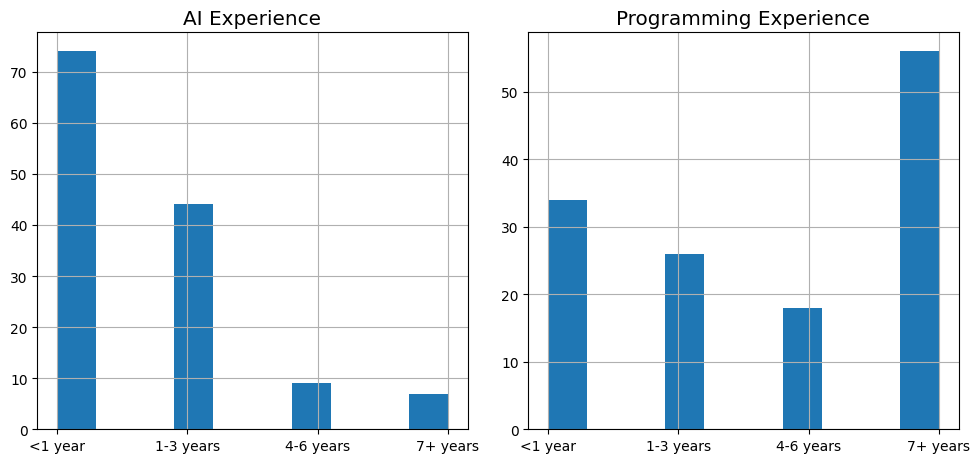

In [7]:
# create fig with subplots
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10) # make it wider
plt.rcParams.update({'font.size': 12}) # increase font size

# add histograms to subplots
s_ai_exp.hist(ax=axs[0])
axs[0].set_title("AI Experience")
axs[0].set_xticks(range(len(order)))
axs[0].set_xticklabels(order)

s_prog_exp.hist(ax=axs[1])
axs[1].set_title("Programming Experience")
axs[1].set_xticks(range(len(order)))
axs[1].set_xticklabels(order)

# add space between plots and show
plt.tight_layout()
plt.show()

### encode dream outcomes

Text(0.5, 1.0, 'Response lengths')

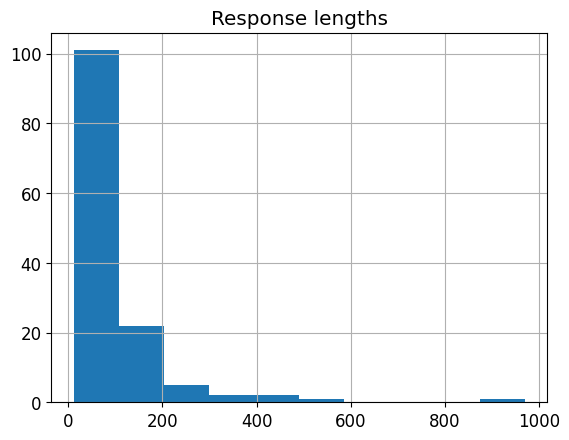

In [8]:
df['dream_outcome'].str.len().hist()
plt.title("Response lengths")

In [9]:
# load model
model = SentenceTransformer("all-mpnet-base-v2")

In [10]:
# compute embeddings
embeddings = model.encode(df['dream_outcome'])
print(embeddings.shape)

(134, 768)


In [11]:
# # openai embeddings
# openai_embedding = client.embeddings.create(input = df['dream_outcome'], model='text-embedding-3-small')

# embedding_list = [embedding_object.embedding for embedding_object in openai_embedding.data]
# embeddings_oai = np.array(embedding_list)
# print(embeddings_oai.shape)

# embeddings = embeddings_oai

### Cluster responses based on similarity

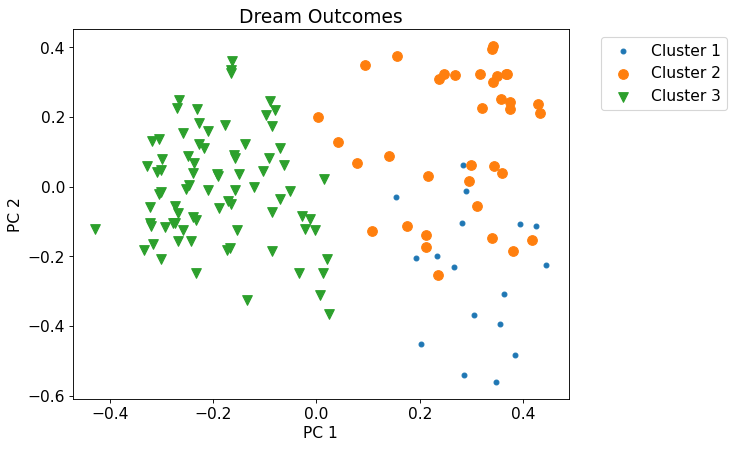

In [12]:
N = 3
kmeans = KMeans(n_clusters=N, random_state=0).fit(embeddings)

X = PCA(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(8, 6), dpi=80)
plt.rcParams.update({'font.size': 14})
marker_list = ['.', 'o', 'v', '^', '<', '>', '1', '2']

for i in range(N):
    plt.scatter(X[kmeans.labels_==i, 0], X[kmeans.labels_==i, 1], label=f"Cluster {i+1}", s=75, marker=marker_list[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Dream Outcomes")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### Summarize responses by cluster

In [13]:
for i in range(N):
    response_series = df['dream_outcome'][kmeans.labels_==i]
    print("Cluster", i+1, "| Size:", len(response_series))
    print("Description:", summarize_responses(client, response_series))
    print("Responses:")
    print(format_responses(response_series))
    print("-------------------------------------")

Cluster 1 | Size: 17
Description: Product Developers
Responses:
- I would like to learn how to practically setup LLM application in a production environment so that I can start creating some AI web apps for internal and external use. 
- Build an app
- able to create a LLM from scratch
- Build cool products
- Build and launch a product
- Being able to implement llms into projects 
- Be able to train a model and have some practical usage of llm.
- I want to build my own MicroSaaS products
- Should be able to build an LLM based solution end2end
- Have a strong foundation on GenAI and LLMs
- Strong Fundamentals on GenAI and LLMs
- To be able to set up my own LLM + RAG system using my own data
- I want to be able to use scripts to automate some of my work and build useful small tools for myself. I'd love to know what LLM frameworks and techniques are out there that would extend my course knowledge. Like a study guide for what's important to advance in LLM engineering
- To at least have a PO